In [1]:
%matplotlib inline
import bt
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

In [2]:
#In this short file, I will be looking at contango: the difference between the pricing of long term volatility and short
# term volatility. 

#Volatility is a good measure of fear in the markets. We can essentially think of it as variance if it could even be put
#that way. When volatility is high, people are fearful and markets move by great amounts. When volatility is low, markets
#barely move at all.

#Short term volatility is volatility in the short term. It is an estimate of how much traders expect the markets to move in
#the short term-in this case, 3 months. We will be using VIX3M.

#Long term volatility is the volatility in the long term. It is the estimate of how much traders expect the markets to move
# in the LONG TERM, in this case, 9 months. We will be using VIX for this matter.

#I hypothesize that when short term volatility is priced higher than long term volatility, it shows that traders are fearful
#in the short term, which is indicative of future declines. I will develop a model that will try to predict market tops using
# the spread between long and short term volatility.

# Before beginning, I would like to note some limitations to this model. Due to the fact that volatility works both ways:
# high variance (volatility) can mean large moves to the upside. In the case of bull markets, like that from 2009 - 2022,
# the spread between long and short term volatility was MEANINGLESS. In fact, short term volatility being priced above
# long term volatility often was bullish: investors expected large moves to the upside in the short term, and so the market's
# variance rose to compensate.

#I will be looking at choatic periods within equity markets: particularly that of 2022, which I will introduce my model with
# and extract data from, and that of the lead up and aftermath of the Great Financial Crisis (2007-2009) where I will
# apply the data from 2022 onto in order to use linear regression in order to predict prices throughout the crisis.

In [3]:
#Let's look at volatility priced 9 months out. I'm going to pull this data from Yahoo Finance. (VIX = 9 month volatility)
VIX = yf.download("^VIX", start="2022-01-01", end="2023-06-07")
VIX = VIX.rename(columns = {'Adj Close':'^VIX'})
VIX = VIX.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
VIX.plot()

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

In [4]:
#Now, let's look at short term volatility priced 3 months out. Again, I'm pulling the data from Yahoo Finance.
VIX3M = yf.download("^VIX3M", start="2022-01-01", end="2023-06-07")
VIX3M = VIX3M.rename(columns = {'Adj Close':'^VIX3M'})
VIX3M = VIX3M.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
VIX3M.plot()

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

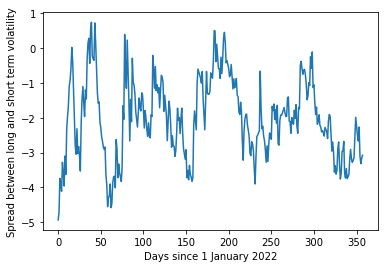

In [5]:
#In order to visualive contango, we'll need to subtract long term volatility (VIX) from the short term volatility (VIX3M).
#Then, we'll put the values into an index (a data frame array) that we can chart.

# The reason why I am choosing around the 2022-2023 timeframe is the great financial uncertainty that is occuring in markets
# that is unlike any in the post-financial crisis, as explained in the beginning.
date = 0
df = {'Date':[],
        'Price':[]}
for x in VIX['^VIX']:
    df['Date'].append(str(VIX.index[date]))
    df['Price'].append(x - VIX3M['^VIX3M'][date])
    date = date + 1
contango = pd.DataFrame(df)
%matplotlib inline
plt.plot(contango['Price'])
plt.xlabel('Days since 1 January 2022')
plt.ylabel('Spread between long and short term volatility')
plt.show()
#Below is the chart for contango: long term volatility minus short term volatility.

In [6]:
#So let's take a look at what happens when contango goes beneath a certain threshold. I picked 3.5 since on the chart shown
#shown above, that is typically the bottom for the 'contango index'. It seems that whenever contango goes beneath 3.5, there
#is a top within equity prices. Let's take a look.

#What the code below will do is to append any instnace of contango being below -3.5 to a list. We'll compare that to a graph
#of the SP500 later.
date = 0
predicted_tops = []
for x in contango['Price']:
    if x < -3:
        predicted_tops.append(contango['Date'][date])
    date = date + 1

[*********************100%***********************]  1 of 1 completed


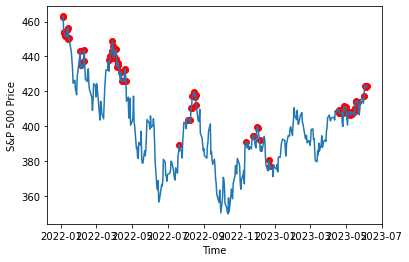

In [7]:
#So here is the S&P 500, downloaded just like from before.

SPY = yf.download("SPY", start="2022-01-01", end="2023-06-07")
SPY = SPY.rename(columns = {'Adj Close':'SPY'})
SPY = SPY.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
SP500 = pd.DataFrame(SPY)

#Let's apply all of the specific points from where contango was below -3.5 to the chart of the S&P 500. Do they really
#predict tops?
for y in predicted_tops:
    for x in SP500.index[:]:
        if str(y) == str(x):
            plt.scatter(x,SP500['SPY'][x],c='Red')
plt.xlabel("Time")
plt.ylabel("S&P 500 Price")
plt.plot(SP500['SPY'])

In [8]:
#Wow~!

#It appears that our contango model works quite well against the market...atleast since the start of 2022. Note that all of
#our red dots are specific points in time when short term volatility was priced HIGHER than long term volatility of at least
#3.5 basis points.

#Whenever this occured, the markets turned out a top within the next few trading days. But how does this look statistically?

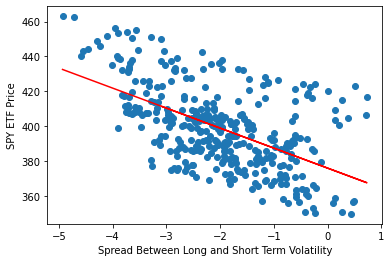

In [9]:
#Let's look at a scatterplot between the contango spread and the price of the S&P500.
plt.xlabel('Spread Between Long and Short Term Volatility')
plt.ylabel('SPY ETF Price')

a, b = np.polyfit(contango['Price'], SP500['SPY'], 1)
plt.plot(contango['Price'], a*contango['Price']+b, c='Red')
plt.scatter(contango['Price'],SP500['SPY'])

In [10]:
#Pretty negatively correlated, huh? The higher the stock market is, the lower the spread between near and long term
#volatility will be.

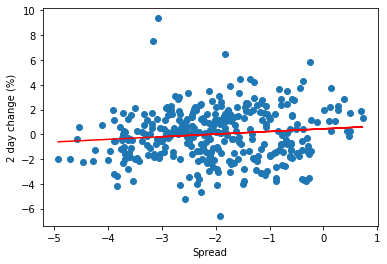

In [11]:
#What the previous cell just did is measure the PRICE of the S&P 500 against that of the spread between long and short term
#volatiltiy (cough cough, contango).

#What this cell will do is to look at the PERFORMANCE of the S&P 500 within the next two days, and compare it with 
#volatility contango.

SPY_change = {'Date':[],
        '2 day change':[]}
for x in range(len(SP500['SPY'])):
    #print(SP500['SPY'][x])
    SPY_change['Date'].append(SP500.index[x])
    if x + 2 < len(SP500):
        SPY_change['2 day change'].append(float(((SP500['SPY'][x+2] - SP500['SPY'][x]) / SP500['SPY'][x])*100))
    else:
        SPY_change['2 day change'].append(float(((SP500['SPY'][len(SP500) - x] - SP500['SPY'][x]) / SP500['SPY'][x])*100))
SPY_two_day_change = pd.DataFrame(SPY_change)

plt.ylabel('2 day change (%)')
plt.xlabel('Spread')
a, b = np.polyfit(contango['Price'], SPY_two_day_change['2 day change'], 1)
plt.scatter(contango['Price'],SPY_two_day_change['2 day change'])
plt.plot(contango['Price'], a*contango['Price']+b, c='Red')

In [12]:
#There is a loose connection between market returns over the next two trading days and level of contango.

#In summary, when short-term volatility is priced higher than long term volatility, the markets will typically have negative
#returns in the short term (i.e, the next two trading days). When long term volatility is priced higher than short term
#volatility, markets can typically look forward to higher returns.

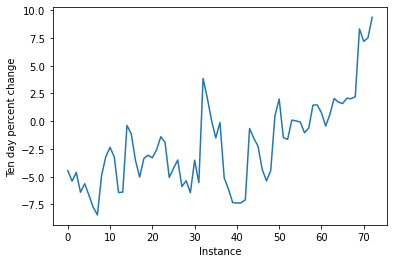

In [13]:
#What we're going to do below is to measure the 10 day percent change of the S&P 500 index whenever contango predicts a top.
#(short term is valued more than long term volatility by a factor of 3.5 basis points. As we've seen in the chart before, 
#this typically indicates a decline in equity prices.

change = {'Date':[],
        '10 day change':[]}
for y in predicted_tops:
    for x in range(len(SP500)):
          if str(y) == str(SP500.index[x]):
                if x + 10 < len(SP500):
                    change['Date'].append(str(y))
                    change['10 day change'].append(float(((SP500['SPY'][x+10] - SP500['SPY'][x]) / SP500['SPY'][x])*100))
                else:
                    change['Date'].append(str(y))
                    change['10 day change'].append(float(((SP500['SPY'][len(SP500) - x] - SP500['SPY'][x]) / SP500['SPY'][x])*100))


ten_day_change = pd.DataFrame(change)
plt.xlabel('Instance')
plt.ylabel('Ten day percent change')
plt.plot(ten_day_change['10 day change'])

#Shown below is all of the changes in the S&P500 whenever contango is -3.5 or below. Notice all of the negative data (except
#one outlier towards the end!). The majority of our instances are negative (y axis below 0). Is volatility contango a good
#way to predict tops? Yes. Is it 100% accurate all the time? No, as seen by the two outliers in our chart below.

In [14]:
#This is all very interesting. But can we apply the same thing towards another turbulent market period? 

#In order to verify the correctness of our model, let's incorporate a bit of machine learning.


In [15]:
#MACHINE LEARNING

#Now that we've shown the connection between contango and future market performance during the timeframe of 2022-2023, let's
# apply it more broadly to other time frames in history. We'll need to choose a chaotic time (as I mentioned in the beginning,
# our model actually is bullish towards contango backwardation during bull markets). 

# 2007 - 2009, the Great Financial Crisis, suits this just well.

#We'll want to use the median and standard deviation in order to predict future prices. What the following cells will attempt
# to do is to apply the data that we learned in our previous 2022 - 2023 simulation and apply it to the 2007 - 2009 timeframe.

median = ten_day_change['10 day change'].median()
stdev = ten_day_change['10 day change'].std()
print(median)

-2.350497352581487


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


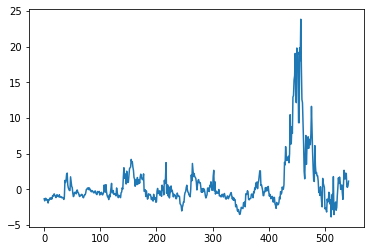

In [16]:
#Redownload our long term 9 month volatility to the period of the 2008 financial crisis.
VIX = yf.download("^VIX", start="2007-01-01", end="2009-03-01")
VIX = VIX.rename(columns = {'Adj Close':'^VIX'})
VIX = VIX.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
#Redownload our short term 3 month volatility to the period of the 2008 financial crisis.
VIX3M = yf.download("^VIX3M", start="2007-01-01", end="2009-03-01")
VIX3M = VIX3M.rename(columns = {'Adj Close':'^VIX3M'})
VIX3M = VIX3M.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
#Now use long and short term volatility to create our Contango index.
date = 0
df = {'Date':[],
        'Price':[]}
for x in VIX['^VIX']:
    df['Date'].append(str(VIX.index[date]))
    df['Price'].append(x - VIX3M['^VIX3M'][date])
    date = date + 1
contango = pd.DataFrame(df)
%matplotlib inline
plt.plot(contango['Price'])
plt.show()

In [17]:
date = 0
predicted_tops = []
for x in contango['Price']:
    if x < -3:
        predicted_tops.append(contango['Date'][date])
    date = date + 1

In [18]:
#So the meat of what this model will do is to take a random number from the median 10 day return and standard deviation
#after a sell-signal from the "predicted tops" array. That number will be added to the market to predict where markets will
#be within the next 10 days.

# In many ways, this is like linear regression. Unfortunately, we can't really use linear regression on stock data unlike
# other data, but what we can use is Monte-Carlo simulations.

In [19]:
#So here is the S&P 500, downloaded just like from before.

SPY = yf.download("SPY", start="2007-01-01", end="2009-03-01")
SPY = SPY.rename(columns = {'Adj Close':'SPY'})
SPY = SPY.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
SP500 = pd.DataFrame(SPY)

[*********************100%***********************]  1 of 1 completed


In [20]:
#Now, let's create a predictions array for where we predict the stock market will be within the next 10 days after our
#contango model signals a sell. After we do this, we'll compare it to our actual data from the actual 2008 financial crisis.
change = {'Date':[],
        'Predicted price after 10 days':[],
         'Actual price after 10 days':[]}
count = 0
for x in SP500.index[:]:
    for y in predicted_tops:
        if str(y) == str(x):
            change['Date'].append(str(y))
            price = SP500['SPY'][count] * (1 + median/100)
            change['Predicted price after 10 days'].append(price)
            if count + 10 < len(SP500):
                change['Actual price after 10 days'].append(SP500['SPY'][count + 10])
            else:
                change['Actual price after 10 days'].append(SP500['SPY'][len(SP500) - count])
    count = count + 1
change = pd.DataFrame(change)
change

,Date,Predicted price after 10 days,Actual price after 10 days
0,2007-12-21 00:00:00,106.136998,101.926575
1,2008-05-16 00:00:00,102.723757,102.423744
2,2008-05-20 00:00:00,102.169301,101.774872
3,2008-05-21 00:00:00,100.441154,103.810081
4,2008-05-22 00:00:00,100.455570,100.499199
5,2008-12-31 00:00:00,66.214375,63.419930
6,2009-01-13 00:00:00,63.917720,65.666679
7,2009-01-21 00:00:00,61.672427,62.615898


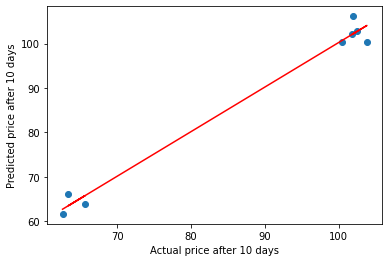

In [21]:
#Create a scatter plot displaying the actual vs predicted price.

plt.scatter(change['Actual price after 10 days'],change['Predicted price after 10 days'])

plt.ylabel('Predicted price after 10 days')
plt.xlabel('Actual price after 10 days')

a, b = np.polyfit(change['Actual price after 10 days'],change['Predicted price after 10 days'], 1)
plt.plot(change['Actual price after 10 days'], a*change['Actual price after 10 days']+b, c='Red')

In [22]:
#So what explains the large gap in the middle?

#Our model did not create any signals when SPY was around those prices. It's important to know that the S&P 500 quickly
# fell through those prices in Fall 2008 after the banking crisis grew evermore apparent. So the S&P 500 didn't spend
# much time around those prices because they literally crashed through them. And as a result, we don't really have much to
# say about them in our data.

#But what does that chart above say? Well firstly, our model predicted the actual price of SPY pretty damn well. One can 
# attribute this to the expected move of the stock market and the fact that the markets only move ~1-3 percent any given
# week typically, but these were volatile times! Our model did pretty well in predicting prices for the time.

# I want to show you something even better.

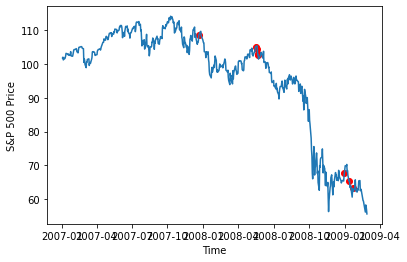

In [23]:
#Let's apply all of the specific points from where contango was below -3 to the chart of the S&P 500. Do they really
#predict tops?

#This is extremely similar to what we did around the 2022-2023 timeframe. This will help us visualize what the markets actually
# did after a peak was signaled by contango.

#Red dots show a sell signal made by our contango model. Note what happens after they signal.

for y in predicted_tops:
    for x in SP500.index[:]:
        if str(y) == str(x):
            plt.scatter(x,SP500['SPY'][x],c='Red')
plt.xlabel("Time")
plt.ylabel("S&P 500 Price")
plt.plot(SP500['SPY'])

In [24]:
#That's kind of cool. But let's look at a chart of the declines in the indice.

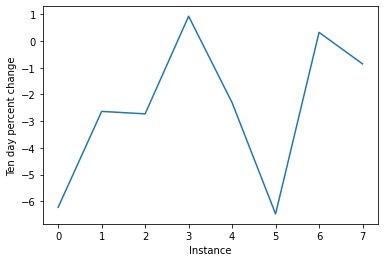

In [25]:
actual_change = {'Date':[],
        '10 day change':[]}
for y in predicted_tops:
    for x in range(len(SP500)):
          if str(y) == str(SP500.index[x]):
                if x + 10 < len(SP500):
                    actual_change['Date'].append(str(y))
                    actual_change['10 day change'].append(float(((SP500['SPY'][x+10] - SP500['SPY'][x]) / SP500['SPY'][x])*100))
                else:
                    actual_change['Date'].append(str(y))
                    actual_change['10 day change'].append(float(((SP500['SPY'][len(SP500) - x] - SP500['SPY'][x]) / SP500['SPY'][x])*100))


actual_ten_day_change = pd.DataFrame(actual_change)
plt.xlabel('Instance')
plt.ylabel('Ten day percent change')
plt.plot(actual_ten_day_change['10 day change'])

In [26]:
# Like the last chart from the 2022-2023 time frame, most of the ten day percent changes are negative. Shocker?! No. If we
#if short term volatility is worth more than long term, then markets probably will top.

In [27]:
#I hope you enjoyed my project. Please reach out to me at my email lvl25@cornell.edu for any questions.

# I understand that past performance does not always equal future performance. Therefore, please only use this model with
# extreme caution. As accurate as this model may have been around 2007 - 2009, or around 2022 - 2023, nothing can be said
# about 2024, or 2025, or so on.

# My findings can be summarized as follows:

# During bear markets, when investors expect the market to move more in the short term (3 months) than the long term
#(9 months), markets are primed for a move downwards due to expectations of a move downwards within the short term. People
# are fearful: and dump their assets, causing them to move downwards within the following 10-20 days.

# More research must be done during bull markets.